In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
import datetime
import matplotlib.pyplot as plt

In [2]:
train_dir = 'data/gmm_saliency/train'
val_dir = 'data/gmm_saliency/validation'
test_dir = 'data/gmm_saliency/testing'

In [3]:
train_datagen = ImageDataGenerator( 
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generator for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_mode='binary'  # Ensure binary class mode
)

# Generator for validation
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,  # Shuffling is okay for validation
    class_mode='binary'
)

# Generator for testing
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    shuffle=False,
    class_mode='binary'  # Testing labels are also binary
)

Found 22046 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'parasitized': 0, 'uninfected': 1}

In [5]:
# Load the base model MobileNetV3Large
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Create the model using Sequential
mobilenetv3_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),  # Stabilize training
    Dropout(0.1),  # Increase dropout
    Dense(256, activation='relu'),
    BatchNormalization(),  # Stabilize training
    Dropout(0.1),
    Dense(1, activation='sigmoid')   # Output layer
])

# Compile the model with a learning rate of 0.01
mobilenetv3_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [6]:


# Update the filepath to use the .keras extension
model_checkpoint_mobilenetv3 = ModelCheckpoint(
    filepath='best_gmm_saliency_mobilenet/best_mobilenetv3_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=2
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Hentikan jika tidak ada perbaikan setelah 10 epoch
    restore_best_weights=True,
    verbose=2
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi learning rate menjadi setengah
    patience=5,  # Setelah 5 epoch tanpa perbaikan
    min_lr=1e-7,  # Batas minimum learning rate
    verbose=2
)

# Tambahkan ke daftar callback
callbacks_mobilenetv3 = [model_checkpoint_mobilenetv3, early_stopping, reduce_lr]

In [7]:
history_mobilenetv3 = mobilenetv3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks_mobilenetv3
)


Epoch 1/50


345/345 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8273
Epoch 1: val_loss improved from inf to 0.27012, saving model to best_gmm_saliency_mobilenet\best_mobilenetv3_model.keras
345/345 [==============================] - 178s 510ms/step - loss: 0.3946 - accuracy: 0.8273 - val_loss: 0.2701 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 2/50
345/345 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.8588
Epoch 2: val_loss did not improve from 0.27012
345/345 [==============================] - 177s 514ms/step - loss: 0.3334 - accuracy: 0.8588 - val_loss: 0.2864 - val_accuracy: 0.8844 - lr: 1.0000e-04
Epoch 3/50
345/345 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.8677
Epoch 3: val_loss improved from 0.27012 to 0.26170, saving model to best_gmm_saliency_mobilenet\best_mobilenetv3_model.keras
345/345 [==============================] - 179s 519ms/step - loss: 0.3169 - accuracy: 0.8677 - val_loss: 0.2617 -

In [8]:
# Paths for saving results and plots
output_csv_path_mobilenet = 'best_gmm_saliency_mobilenet/mobilenet_best_gmm_saliency_mobilenet_test_results.csv'
roc_curve_path_mobilenet = 'best_gmm_saliency_mobilenet/mobilenet_best_gmm_saliency_mobilenet_roc_curve.png'

# Get true labels and predictions
y_true = test_generator.classes
y_pred_prob = mobilenetv3_model.predict(test_generator)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Get filenames
filenames = test_generator.filenames

# Create DataFrame for results
results_df = pd.DataFrame({
    'Nama File': filenames,
    'Label Asli': y_true,
    'Prediksi': y_pred.flatten()
})

# Calculate Metrics
mcc_mobilenet = matthews_corrcoef(y_true, y_pred)
auc_roc_mobilenet = roc_auc_score(y_true, y_pred_prob)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print Metrics
print(f"MobilenetV3 Metrics:\n"
      f"MCC: {mcc_mobilenet}\n"
      f"AUC-ROC: {auc_roc_mobilenet}\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1-Score: {f1}")

# Append metrics to DataFrame for the entire dataset
results_df['MCC'] = [mcc_mobilenet] * len(results_df)
results_df['AUC-ROC'] = [auc_roc_mobilenet] * len(results_df)
results_df['Accuracy'] = [accuracy] * len(results_df)
results_df['Precision'] = [precision] * len(results_df)
results_df['Recall'] = [recall] * len(results_df)
results_df['F1-Score'] = [f1] * len(results_df)

# Save the results to CSV
results_df.to_csv(output_csv_path_mobilenet, index=False)
print(f"Hasil prediksi MobilenetV3 disimpan di {output_csv_path_mobilenet}")

# Plot and save ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)  # Use probabilities directly
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig(roc_curve_path_mobilenet)
plt.close()


22/22 [==============================] - 11s 489ms/step
MobilenetV3 Metrics:
MCC: 0.8476079701424297
AUC-ROC: 0.980417971819237
Accuracy: 0.9223512336719883
Precision: 0.8900804289544236
Recall: 0.9637155297532656
F1-Score: 0.9254355400696864
Hasil prediksi MobilenetV3 disimpan di best_gmm_saliency_mobilenet/mobilenet_best_gmm_saliency_mobilenet_test_results.csv


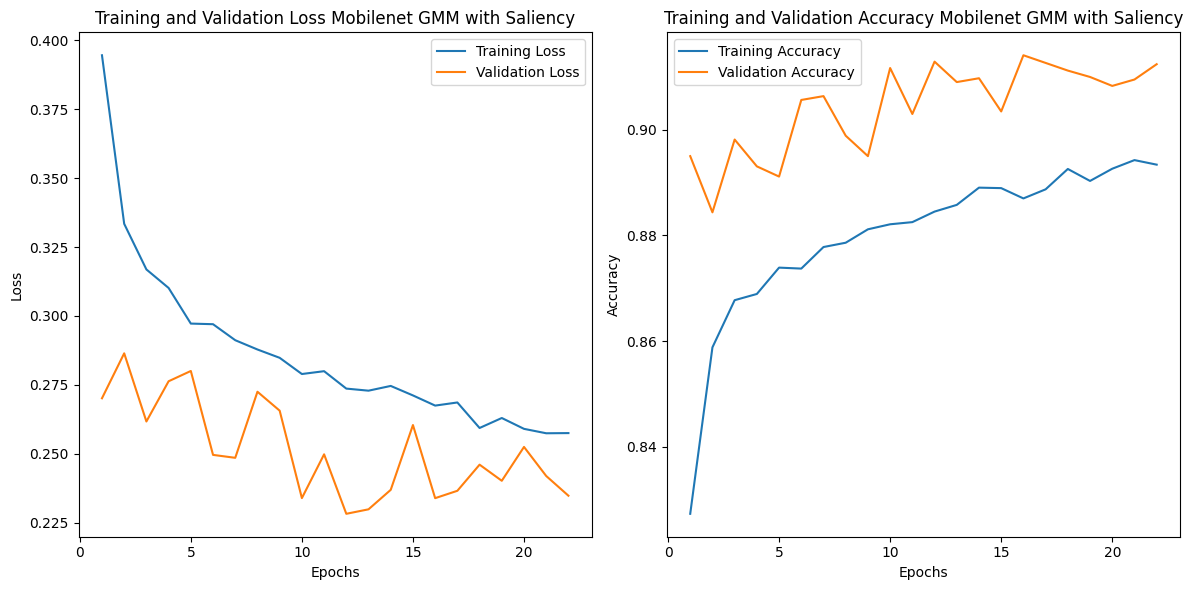

In [9]:
import matplotlib.pyplot as plt

# Ambil data dari history
history = history_mobilenetv3.history
epochs = range(1, len(history['loss']) + 1)

# Buat plot
plt.figure(figsize=(12, 6))

# Plot Loss dan Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Mobilenet GMM with Saliency')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy dan Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Mobilenet GMM with Saliency')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Simpan plot
plt.tight_layout()
plt.savefig('training_validation_metrics.png', dpi=300)  # Simpan gambar dengan nama file dan resolusi
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


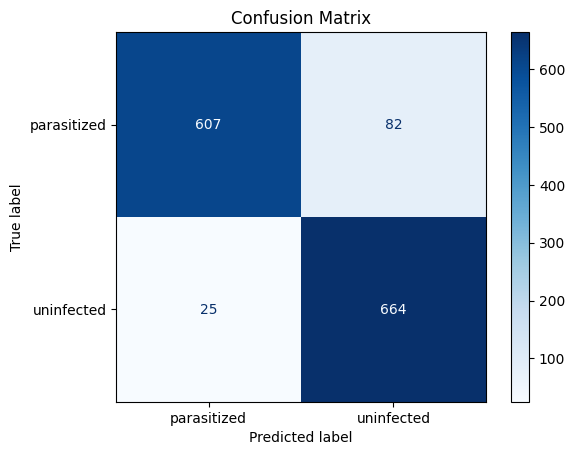

In [11]:
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix dengan visualisasi
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
